In [1]:
import numpy as np
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt

/home/mwagner/bin/anaconda3/envs/hcprediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Bell-shaped input

This code generates a synthetic neural activity input matrix X_mini for training/testing a vanilla RNN (Elman RNN) where each neuron has a time-shifted Gaussian (bell-shaped) activity profile.

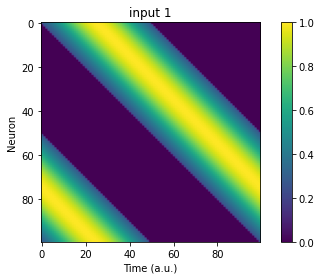

In [2]:
# Generate input/target ranging from (0,1) for sigmoid nonlinearity (i.e. removed the softmax constrain)
Path = "Elman_SGD/Remap_predloss/"

# parameters
N, TotalSteps, T = 100, 2000, 100  # neurons, total time steps, downsampled steps

# initialize input (N x T)
X = np.zeros((np.int64(N), np.int64(TotalSteps)))

# create Gaussian "bump" (bell-shaped curve)
tmp = np.linspace(norm.ppf(0.05), norm.ppf(0.95), np.int64(TotalSteps / 2))
BellShape = norm.pdf(tmp)  # Bellshape vector

# build template activite: half Gaussian bump, half zeros
template = np.concatenate((BellShape, np.zeros(np.int64(TotalSteps / 2))))

# reinitialize X to build the time-shifting matrix
X = np.zeros((np.int64(N), np.int64(TotalSteps)))

# shift the template by a fixed amount to make sequentially activate neurons
for i in np.arange(np.int64(N)):
    X[i, :] = np.roll(template, np.int64(i * (TotalSteps / N)))

# select T evenly spaced time steps out of total number (downsampling)
Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)

# take only the sampled points and transpose so time is the first axis (rows)
tmp = np.expand_dims((X[:, Select_T].T), axis=0)

# normalize inputs
tmp = tmp / tmp.max()

# convert to PyTorch and save
X_mini = torch.tensor(tmp.astype(np.single))
# torch.save(
#    {"X_mini": X_mini, "Target_mini": X_mini},
#    Path + "Ns{}_SeqN{}_1.pth.tar".format(N, T),
# )

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 1")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
# plt.savefig(Path + "Ns{}_SeqN{}_1.png".format(N, T))
plt.show()

# One-hot encoding

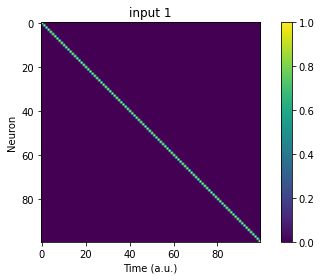

In [ ]:
# parameters
data_path = "../data/Ns100_SeqN100/"
N, TotalSteps, T = 100, 2000, 100
active = (np.arange(TotalSteps) * N) // TotalSteps
X = np.zeros((N, TotalSteps), dtype=np.float32)
X[active, np.arange(TotalSteps)] = 1.0
Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp, dtype=torch.float32)
# torch.save(
#    {"X_mini": X_mini, "Target_mini": X_mini},
#    data_path + "Ns{}_SeqN{}_1hot.pth.tar".format(N, T),
# )

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 1")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
# plt.savefig(data_path + "Ns{}_SeqN{}_1hot.png".format(N, T))
plt.show()

# Noisy Env 1

/home/mwagner/bin/anaconda3/envs/hcprediction/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


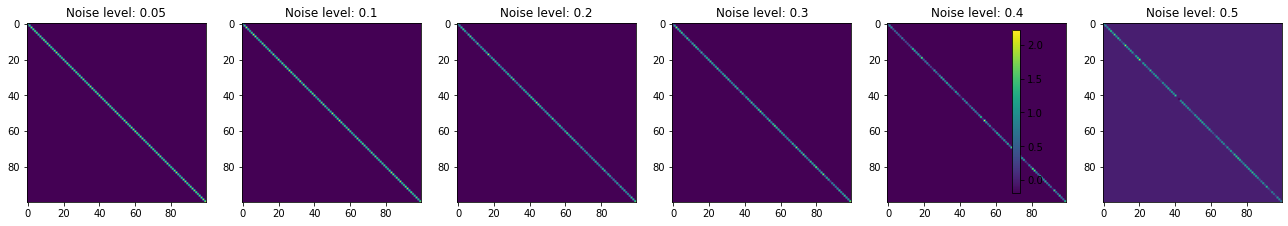

In [4]:
# Save a noisy version of env 1
# Independent random gaussian noise N~(0,activity*noise_level)
noise_level = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
torch.manual_seed(0)
fig, axes = plt.subplots(1, len(noise_level), figsize=(18, 3))

for i in range(len(noise_level)):
    X_noisy = X_mini + torch.normal(mean=0, std=noise_level[i] * X_mini)
    # torch.save(
    #    {"X_mini": X_noisy, "Target_mini": X_noisy},
    #    Path + "Ns{}_SeqN{}_1_{}per.pth.tar".format(N, T, int(noise_level * 100)),
    # )

    im = axes[i].imshow(X_noisy[0, :, :].T.numpy())
    axes[i].set_title(f"Noise level: {noise_level[i]}")

    # plt.savefig(Path + "Ns{}_SeqN{}_1_{}per.png".format(N, T, int(noise_level * 100)))
fig.colorbar(im, ax=axes, orientation="vertical")
plt.tight_layout()
plt.show()

# Env 2

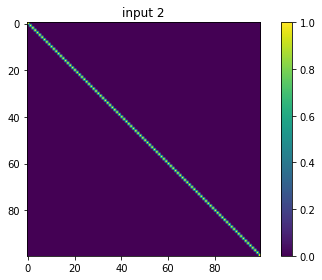

In [4]:
# Create randomly permuted environment 2
np.random.seed(2)
idx = np.random.permutation(np.arange(N))
X_new = X_mini[:, :, idx]
# torch.save(
#    {"X_mini": X_new, "Target_mini": X_new}, Path + "Ns{}_SeqN{}_2.pth.tar".format(N, T)
# )

plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 2")
plt.tight_layout()
# plt.savefig(Path + "Ns{}_SeqN{}_2.png".format(N, T))
plt.show()

# k-hot encoding

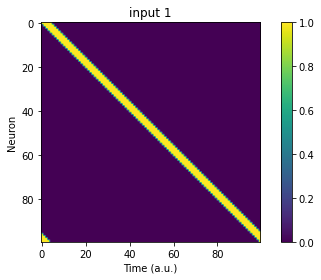

In [ ]:
# parameters
data_path = "../data/Ns100_SeqN100/"
N, TotalSteps, T = 100, 2000, 100
k = 5  # number of simultaneously active neurons

active = (np.arange(TotalSteps) * N) // TotalSteps
X = np.zeros((N, TotalSteps), dtype=np.float32)

for t in range(TotalSteps):
    idx = active[t]
    # window size of k centered at idx, wrapping circularly
    for offset in range(-(k - 1), 1):
        X[(idx + offset) % N, t] = 1.0

Select_T = np.arange(0, TotalSteps, np.int64(TotalSteps / T), dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp, dtype=torch.float32)
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_{}hot.pth.tar".format(N, T, k),
)

# plot and save plot
plt.figure()
plt.imshow(X_mini[0, :, :].T.numpy())
plt.colorbar()
plt.title("input 1")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.tight_layout()
plt.savefig(data_path + "Ns{}_SeqN{}_{}hot.png".format(N, T, k))
plt.show()

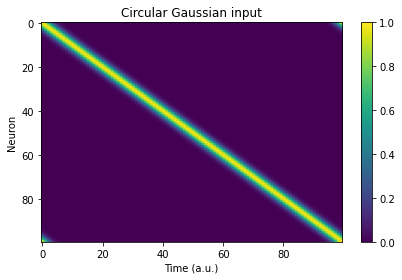

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- params ---
data_path = "../data/Ns100_SeqN100/"
N, TotalSteps, T = 100, 2000, 100  # neurons, total steps, downsampled steps

# choose width: either set k (FWHM ~ k) or set sigma directly
k = 5  # try 5–10 for N=100
sigma = k / 2.355  # convert FWHM (k) -> sigma

# optional phase shift to move bump above/below diagonal (negative = above)
shift = 0  # e.g., -2 for a slight upward tilt

# center index over time (uniformly moving around the ring)
centers = ((np.arange(TotalSteps) * N) // TotalSteps + shift) % N  # (TotalSteps,)


def circ_dist(i, j, N):
    d = np.abs(i - j)
    return np.minimum(d, N - d)


# build Gaussian on a ring
X = np.zeros((N, TotalSteps), dtype=np.float32)
idx = np.arange(N)
for t, c in enumerate(centers):
    d = circ_dist(idx, c, N)
    X[:, t] = np.exp(-0.5 * (d / sigma) ** 2)

# normalize each time slice to [0,1] (keeps dynamic range consistent)
X /= X.max(axis=0, keepdims=True)

# downsample to T and convert to (1, T, N) for your model
Select_T = np.arange(0, TotalSteps, TotalSteps // T, dtype=int)
tmp = X[:, Select_T].T[None, :, :]  # (1, T, N)
X_mini = torch.tensor(tmp.astype(np.float32))
torch.save(
    {"X_mini": X_mini, "Target_mini": X_mini},
    data_path + "Ns{}_SeqN{}_{}gauss.pth.tar".format(N, T, k),
)

# quick plot
plt.figure()
plt.imshow(X_mini[0].numpy().T, aspect="auto")
plt.colorbar()
plt.title("Circular Gaussian input")
plt.ylabel("Neuron")
plt.xlabel("Time (a.u.)")
plt.savefig(data_path + "Ns{}_SeqN{}_{}gauss.png".format(N, T, k))
plt.tight_layout()
plt.show()